# FIT3164 Final Year Project
**Team Name:** MDS07

**Supervisor:** Dr. Lim Mei Kuan

**Topic:** Detecting ChatGPT Output  - Is AI better than Humans

**Members:**
1. Daryl Khoo Kah Hui (SD)
2. Lo Kin Herng (QA)
3. Sim Ee Leen (PM)

The purpose of this software testing tool is to prompt ChatGPT to generate articles, which are then pipelined into GPTZero for evaluation. Finally, a dashboard is displayed for visualisation purposes. Essentially, the program consists of 3 modules, which are:

Generation, Evaluation and Visualisation

The program is executed by running all cells. The user is first prompted to provide the file paths for 2 text files which contain the secret API keys for ChatGPT and GPTZero respectively. Then the user selects a mode. The program can be run in 3 modes which are:

1. Generate, evaluate and visualise
2. Evaluate and visualise
3. Visualise only

The user is requied to input different inputs based on the selected mode.

For mode 1, the user is expected to input:
1. A file path with .json extension containing the title and short descriptions
2. A prompt based on the format specified
3. A file path with .json extension which will store the generated articles from ChatGPT
4. A file path with .json extension which will store the results from GPTZero
5. A title for the dashboard [Optional]

For mode 2, the user is expected to input:
1. A file path with .json extension containing the generated articles from ChatGPT
2. A file path with .json extension which will store the results from GPTZero
3. A title for the dashboard [Optional]

For mode 3, the user is expected to input:
1. A file path with .json extension containing the generated articles from ChatGPT
2. A file path with .json extension containing the results from GPTZero
3. A title for the dashboard [Optional]





# Installing Necessary Libraries
We install relevant libraries listed in requirements.txt to assist us in our project.

In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 112.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
  Attempting uninstall: scikit-learn
    Found

# Importing Necessary Libraries

In [ ]:
import openai
import pandas as pd

import json
import requests
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import webbrowser

# Input Validation Functions
Contains helper functions to validate inputs.


In [ ]:
def validate_txt_file(txt_file):
    """
    This function performs validation on the text file inputted.

    Args:
        txt_file (str): name of file (txt format)

    Returns: None.
    """
    if not txt_file.endswith('.txt'):
        raise ValueError("Invalid file format. Please provide a .txt file.")

    try:
        with open(txt_file, 'r') as file:
            file_content = file.read()
            if not file_content.strip():
                raise ValueError("File is empty.")
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Error: File not found. Please provide a valid file path.")


def json_file_exists(json_file):
    """
    This function performs validation on the JSON file inputted, ensuring the file exists and is not corrupted.

    Args:
        json_file (str): name of file (JSON format)

    Returns: None.
    """
    with open(json_file, 'r') as file:
        json_data = json.load(file)


def check_is_json(json_file):
    """
    This function checks if the file is in JSON format.

    Args:
        json_file (str): name of file (JSON format)

    Returns: None.
    """
    if not json_file.endswith('.json'):
        raise ValueError("Invalid file format. Please provide a .json file.")


def check_col(json_file, col):
    """
    This function checks if a file contains the specified key. Raises an error if the key is not present.

    Args:
        json_file (str): name of file (JSON format)
        col (str): column name

    Returns: None.
    """
    with open(json_file, 'r') as file:
        data = file.read()
        parsed_data = json.loads(data)
        for dictionary in parsed_data:
            if col not in dictionary:
                raise ValueError(f"File is missing {col} column")


def check_error(json_file):
    """
    This function checks if a file contains "error" as a key. Raises an error if the key is present.

    Args:
        json_file (str): name of file (JSON format)

    Returns: None.
    """
    with open(json_file, 'r') as file:
        data = file.read()
        parsed_data = json.loads(data)
        for dictionary in parsed_data:
            if "error" in dictionary:
                raise ValueError("File has 'error' key. Something went wrong during evaluation phase.")


def check_json_length(json_file):
    """
    Returns the number of entries in the json file.

    Args:
        json_file (str): name of file (JSON format)

    Returns:
        len: The number of entries in the json file.
    """
    with open(json_file, 'r') as file:
        data = file.read()
        parsed_data = json.loads(data)
        return len(parsed_data)


def validate_prompt(prompt):
    """
    Checks if the prompt is valid by checking if both '{title}' and '{short_description}' are present in the prompt

    Args:
        prompt (str): prompt used to prompt ChatGPT

    Returns: None.
    """

    if "'{title}'" not in prompt:
        raise ValueError("Prompt must contain '{title}'. Please encapsulate title with {} followed by ''")
    elif "'{short_description}'" not in prompt:
        raise ValueError("Prompt must contain '{short_description}'. Please encapsulate short_description with {} followed by ''")


# Requesting User Input

Here, the user inputs the file names/paths accordingly.

In [ ]:
cgpt_key_loop = True
gptzero_key_loop = True

mode_selection_loop = True

mode_1_title_content_loop = True
mode_1_prompt_loop = True
mode_1_dataset_loop =  True
mode_1_results_loop = True

mode_2_dataset_loop = True
mode_2_results_loop = True

mode_3_dataset_loop = True
mode_3_results_loop = True

while cgpt_key_loop:
    try:
        cgpt_key_path = input("Please input the file name/path that contains the ChatGPT API key. ")
        validate_txt_file(cgpt_key_path)
    except ValueError as e:
        print(e)
    except FileNotFoundError as e:
        print(e)
    else:
        cgpt_key_loop = False
        print(f"File '{cgpt_key_path}' successfully validated.")

while gptzero_key_loop:
    try:
        gptzero_key_path = input("Please input the file name/path that contains the GPTZero API key. ")
        validate_txt_file(gptzero_key_path)
    except ValueError as e:
        print(e)
    except FileNotFoundError as e:
        print(e)
    else:
        gptzero_key_loop = False
        print(f"File '{gptzero_key_path}' successfully validated.")

while mode_selection_loop:
    try:
        mode = int(input("Please enter a number based on the following configurations:\nMode 1: Generate, evaluate and visualise\nMode 2: Evaluate and Visualise\nMode 3: Visualise only\n"))
    except ValueError as e:
        print("Please insert a number, not text.\n")
    else:
        if mode == 1:
            generation_flag = True
            evaluation_flag = True
            mode_selection_loop = False

            while mode_1_title_content_loop:
                try:
                    cgpt_title_content_path = input("Please input the file name/path of the file that contains the title and short description.")
                    check_is_json(cgpt_title_content_path)                        # Checks that the file has .json extension
                    json_file_exists(cgpt_title_content_path)                     # Checks if the file exists and is not corrupted
                    check_col(cgpt_title_content_path, "title")                   # Check if the file has the title column
                    check_col(cgpt_title_content_path, "short_description")       # Check if the file has the short_description column
                    check_col(cgpt_title_content_path, "generated_by")            # Check if the file has the generated_by column
                except Exception as e:
                    print(e)
                else:
                    mode_1_title_content_loop = False
                    print(f"File '{cgpt_title_content_path}' successfully validated.\n")

            while mode_1_prompt_loop:
                try:
                    prompt = input("Please enter a prompt.")
                    validate_prompt(prompt)                                 # Check if prompt contains title and short description in the right format
                except ValueError as e:
                    print(e)
                else:
                    mode_1_prompt_loop = False
                    print(f"Prompt is valid.")

            while mode_1_dataset_loop:
                try:
                    dataset_name = input("Please provide a suitable file name/path for your generated articles. ")
                    check_is_json(dataset_name)                                   # Checks that the file has .json extension
                except Exception as e:
                    print(e)
                else:
                    mode_1_dataset_loop = False
                    print(f"File '{dataset_name}' successfully validated.\n")

            while mode_1_results_loop:
                try:
                    gpt_zero_results_filename = input("Please provide a suitable file name/path for the GPTZero results file. ")
                    check_is_json(gpt_zero_results_filename)                        # Checks that the file has .json extension
                    if gpt_zero_results_filename == dataset_name:
                        raise ValueError("You can't use the same name for both files. Please provide a different name. ")
                except Exception as e:
                    print(e)
                else:
                    mode_1_results_loop = False
                    print(f"File '{gpt_zero_results_filename}' successfully validated.\n")

            dashboard_title = input("Please enter a title for the dashboard. Press enter if you do not wish to provide a title.")
            print(f"Dashboard title is valid.")
            print("\nAll configurations set up successfully.")

        elif mode == 2:
            generation_flag = False
            evaluation_flag = True
            mode_selection_loop = False

            while mode_2_dataset_loop:
                try:
                    dataset_name = input("Please input the file name/path of the generated articles. ")
                    check_is_json(dataset_name)                        # Checks that the file has .json extension
                    json_file_exists(dataset_name)                     # Checks if the file exists and is not corrupted
                    check_col(dataset_name, "text")                    # Check if the file has the text column
                except Exception as e:
                    print(e)
                else:
                    mode_2_dataset_loop = False
                    print(f"File '{dataset_name}' successfully validated.\n")

            while mode_2_results_loop:
                try:
                    gpt_zero_results_filename = input("Please provide a suitable file name/path for the GPTZero results file. ")
                    check_is_json(gpt_zero_results_filename)          # Checks that the file has .json extension
                except Exception as e:
                    print(e)
                else:
                    mode_2_results_loop = False
                    print(f"File '{gpt_zero_results_filename}' successfully validated.\n")

            dashboard_title = input("Please enter a title for the dashboard. Press enter if you do not wish to provide a title.")
            print(f"Dashboard title is valid.")

            print("\nAll configurations set up successfully.")

        elif mode == 3:
            generation_flag = False
            evaluation_flag = False
            mode_selection_loop = False

            while mode_3_dataset_loop:
                try:
                    dataset_name = input("Please input the file name/path of the generated articles. ")
                    check_is_json(dataset_name)                        # Checks that the file has .json extension
                    json_file_exists(dataset_name)                     # Checks if the file exists and is not corrupted
                    check_col(dataset_name, "generated_by")            # Checks if the file has the generated_by column
                    length_dataset = check_json_length(dataset_name)   # Get the number of entries in the file
                except Exception as e:
                    print(e)
                else:
                    mode_3_dataset_loop = False
                    print(f"File '{dataset_name}' successfully validated.\n")

            while mode_3_results_loop:
                try:
                    gpt_zero_results_filename = input("Please input the file name/path of the GPTZero results file. ")
                    check_is_json(gpt_zero_results_filename)                       # Checks that the file has .json extension
                    json_file_exists(gpt_zero_results_filename)                    # Checks if the file exists and is not corrupted
                    check_error(gpt_zero_results_filename)                         # Checks if the file has the error column
                    length_results = check_json_length(gpt_zero_results_filename)  # Get the number of entries in the file
                except Exception as e:
                    print(e)
                else:
                    mode_3_results_loop = False
                    print(f"File '{gpt_zero_results_filename}' successfully validated.\n")

            # Check if input articles and results file have same length
            if length_dataset != length_results:
                raise ValueError("The length of the dataset and the length results file differ. Ensure they are the same length.")
            else:
                dashboard_title = input("Please enter a title for the dashboard. Press enter if you do not wish to provide a title.")
                print(f"Dashboard title is valid.")
                print("\nAll configurations set up successfully.")
        else:
            print("Invalid mode selected")
            print()

"""
#### Sample inputs ####

cgpt_key_path = "secret_cgpt.txt"
gptzero_key_path = "secret_gptzero.txt"

cgpt_title_content_path = "title_short_desc.json"
prompt = "As a Generative AI, write a news article about '{title}' in 500 words, given a short description of '{short_description}'."
dataset_name = "ds_role_robot_temp0.5.json"
gpt_zero_results_filename = "hypo16_results_role_robot_temp0.5.json"

dashboard_title = "Hypothesis Testing: Prompt Engineering with Role Based Factor"
"""

Please input the file name/path that contains the ChatGPT API key. secret cgpt.txt
Error: File not found. Please provide a valid file path.
Please input the file name/path that contains the ChatGPT API key. secret_cgpt.txt
File 'secret_cgpt.txt' successfully validated.
Please input the file name/path that contains the GPTZero API key. secret_gptzero.txt
File 'secret_gptzero.txt' successfully validated.
Please enter a number based on the following configurations:
Mode 1: Generate, evaluate and visualise
Mode 2: Evaluate and Visualise
Mode 3: Visualise only
3
Please input the file name/path of the generated articles. ds_content_writer.json
File 'ds_content_writer.json' successfully validated.

Please input the file name/path of the GPTZero results file. res_content_writter.json
Error: File not found. Please provide a valid file path.
Please input the file name/path of the GPTZero results file. res_content_writer.json
File 'res_content_writer.json' successfully validated.

Please enter a 

'\n#### Sample inputs ####\n\ncgpt_key_path = "secret_cgpt.txt"\ngptzero_key_path = "secret_gptzero.txt"\n\ncgpt_title_content_path = "title_short_desc.json"\nprompt = "As a Generative AI, write a news article about \'{title}\' in 500 words, given a short description of \'{short_description}\'."\ndataset_name = "ds_role_robot_temp0.5.json"\ngpt_zero_results_filename = "hypo16_results_role_robot_temp0.5.json"\ndataset_name = "ds_role_robot.json"\ngpt_zero_results_filename = "ds14_robot.json"\n\ndashboard_title = "Hypothesis Testing: Prompt Engineering with Role Based Factor"\n\n\ncgpt_key_path = "secret_cgpt.txt"\ngptzero_key_path = "secret_gptzero.txt"\n'

# Setup and Load Secret Key from OpenAI API and GPTZero API
We read our secret API key obtained from OpenAI and GPTZero.

In [ ]:
f = open(cgpt_key_path)

key = f.read()

openai.api_key = key
# print(openai.api_key) # Printing for checking purposes. Should hide it.
print("ChatGPT API Key set.")

f = open(gptzero_key_path)

key = f.read()

gptzero_api_key = key
# print(gptzero_key) # Printing for checking purposes. Should hide it.
print("GPTZero API Key set.")

ChatGPT API Key set.
GPTZero API Key set.


# Helper Functions
Contains various helper functions for the generation, evaluation and visualization modules.

In [ ]:
############# Generation module helper functions (ChatGPT) #############
def get_completion(prompt, model = "gpt-3.5-turbo", temperature = 0):
    """
    This function makes it easier to use prompts and look at the generated outputs.

    Args:
        prompt (str): prompt used
        model (str): type of GPT model used

    Returns:
        str: Response message based on prompt used
    """
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model = model,
        messages = messages,
        temperature = temperature, # Degree of randomness of the model's output
    )
    return response.choices[0].message["content"]


def generate_dataset(filename, prompt):
    """
    Generates a dataset using ChatGPT API based on the prompt given.

    Args:
        filename (str): name of file (JSON format)
        prompt (str): prompt used

    Returns: A completely generated dataset.
    """
    df = pd.read_json(filename)
    df = df.drop(["content", "generated_by"], axis = 1)
    df["text"] = None

    for _ in range(10):
        try:
            for i, row in df.iterrows():
                if row["text"] is None:
                    title = row["title"]
                    short_description = row["short_description"]

                    new_prompt = prompt.replace('{title}', title)
                    new_prompt = prompt.replace('{short_description}', short_description)

                    prompt_used = new_prompt
                    response = get_completion(prompt_used)
                    # print(response)
                    print(i)

                    df.loc[i, "text"] = response
        except:
            print("Crash :')")
            continue
        break

    df["generated_by"] = "AI"
    df["prompt"] = prompt

    print("Dataset generated successfully.")
    return df


def content_checker(df):
    """
    Loops the dataset generated and checks if there's text in each record of the "text" column.

    Args:
        df (dataframe): generated dataframe

    Returns: None.
    """
    for i in range(len(df)):
        if df["text"][i] is not None:
            continue
        else:
            raise Exception("News article's content has error.")

    print("Done.")


def output_to_json(df, output_filename):
    """
    Outputs the generated dataset to a JSON formatted file.

    Args:
        df (dataframe): generated dataframe
        output_filename: name of output file (JSON format)

    Returns: None.
    """
    df.to_json(output_filename, orient = 'records')

    print("Successfully created JSON file.")



############# Evaluation module helper functions (GPTZero) #############
def read_file(file_name):
    """
    Reads a JSON file. Returns a list of python dictionaries.

    Args:
        file_name (str): A string representing the file name

    Returns: list of python dictionaries.
    """
    try:
        with open(file_name, 'r') as json_file:
            data = json_file.read()
            parsed_data = json.loads(data)
    except json.JSONDecodeError as e:
        raise ValueError(f"The file '{file_name}' is not valid JSON. Error: {e}")
    except FileNotFoundError:
        raise FileNotFoundError(f"The file '{file_name}' does not exist.")
    else:
        return parsed_data


def connect_gpt_zero(doc):
    """
    Sends a text to GPTZero. Returns the output from GPTZero in JSON.

    Args:
        doc (str): A string representing the text

    Returns: Output from GPTZero in JSON format.
    """

    url = "https://api.gptzero.me/v2/predict/text"

    payload = {
        "document": doc,
        "version": "2023-07-19"
    }

    headers = {
        "x-api-key": gptzero_api_key,
        "Content-Type": "application/json",
        "Accept": "application/json"
    }
    try:
        response = requests.post(url, json=payload, headers=headers)
    except requests.exceptions.RequestException as e:
        raise ValueError(f"An error occurred during the request: {e}")
    else:
        if response.status_code == 400:
            raise ValueError("Error Code 400. Problem occurred when validating the data in the request. The error message should clarify the problem.")
        elif response.status_code == 404:
            raise ValueError("Error Code 404. Occurs when we are unable to find your profile, plan or API key, or when your API key is expired.")
        elif response.status_code == 429:
            raise ValueError("Error Code 429. Occurs either when the word limit is reached, or when the hourly rate limit is reached. Sometimes, when this error occurs, it means that you did not add the API key to the header in the proper format, making you get the rate-limit of a free user instead of a paid API user.")
        elif response.status_code == 500:
            raise ValueError("Internal Server Error. This can occur if there is an unexpected error processing your text, or if one of our upstream services failed unexpectedly.")
        else:
            return response.json()


def mass_checking(n, inputs):
    """
    Send n number of articles to GPTZero. Articles are extracted from an input file.
    Returns a list of dictionaries. Each dictionary is the output from GPTZero.

    Args:
        n (int): number of articles to send
        inputs (list): a list of python dictionaries

    Returns: List of dictionaries. Each dictionary is the output from GPTZero.
    """

    output_list = []
    counter = 10
    for i in range(n):
        batch = n//10
        output = connect_gpt_zero(inputs[i]["text"])
        output_list.append(output)

        # print statement to show progress
        if i != 0 and i%batch == 0:
            print(str(counter) +"% done")
            counter += 10
    return output_list


def write_to_json(data, filename):
    """
    Writes some data to a Json file.

    Args:
        data (list): A list of dictionaries
        filename (str):  A string representing the file name

    Returns: None
    """
    with open(filename, 'w') as json_file:
        json.dump(data, json_file)

def check_gptzero_output(results):
    """
    Raises an error if an element in the results file has the error key.

    Args:
        results (list):  A list of dictionaries representing the output from GPTZero

    Returns: None
    """
    for i in range(len(results)):
        if "documents" not in results[i]:
            error_message = results[i]["error"]
            raise ValueError(error_message)

def run(data, filename, flag = False):
    """
    Main code.
    If flag is true, sends a list of input articles to GPTZero for evaluation. Writes the output of GPTZero to a JSON file.
    Does nothing if flag is false.

    Args:
        data (list): A list of dictionaries
        filename (str):  A string representing the file name
        flag (bool): A flag to indicate whether to send data to GPTZero for evaluation.

    Returns: None
    """
    if flag:
        n = len(data)
        print("Sending data...")
        output = mass_checking(n, data)
        write_to_json(output, filename)
        print("Done")
    else:
        print("All good, nothing was sent.")



############# Visualisation module helper functions (Dashboard) #############
def compute_avg_perplexity(results):
    """
    Computes the average perplexity across all articles.

    Args:
        results (list):  A list of dictionaries representing the output from GPTZero

    Returns: The average perplexity across all articles.
    """
    average = 0

    # For each article
    for i in range(len(results)):
        pp_per_article = 0
        metrics = results[i]["documents"][0]
        sentences = metrics["sentences"]
        num_sentences = len(sentences)

        # For each article, get the average perplexity score
        for sentence in sentences:
            pp_per_article += sentence["perplexity"]
        average += pp_per_article/num_sentences

    # Get the average perplexity score for n articles
    overall_average = average/len(results)
    return round(overall_average,2)


def compute_avg_burstiness(results):
    """
    Computes the overall burstiness across all articles.

    Args:
        results (list):  A list of dictionaries representing the output from GPTZero

    Returns: The overall burstiness across all articles.
    """
    total = 0
    for i in range(len(results)):
        metrics = results[i]["documents"][0]
        total += metrics["overall_burstiness"]
    average = total/len(results)
    return round(average,2)

# Main Function for Generation Module.
Read input files and generates a dataset using ChatGPT API. For a dataset containing 100 articles, it will take approximately 20-40mins to generate. "Dataset generated successfully" will be printed when the code block below has run successfully.

In [ ]:
if generation_flag:
    # Insert your prompt to the prompt variable.
    # Create df variable and call function to generate dataset.
    df = generate_dataset(cgpt_title_content_path, prompt)

    # Check the contents of "text" column in the dataframe to ensure each cell is not None.
    content_checker(df)

    # Print the dataframe.
    df

    # Output the dataframe to a JSON formatted file.
    output_to_json(df, dataset_name)

# Main Function for Evaluation Module. Sends articles to GPTZero for evaluation.

Reads input files and sends to GPTZero for evaluation. It should take about 2 minutes for a dataset of 100 articles. "Done" will be printed when the code has run successfully.


In [ ]:
input_articles_filename = dataset_name
input_articles = read_file(input_articles_filename)

# print(len(input_articles)) # Check size of input
# pprint(input_articles[0])  # Check input

test = run(input_articles, gpt_zero_results_filename, evaluation_flag)

All good, nothing was sent.


# Read the output file (GPTZero results)

The file should appear in your directory after running the code above.

In [ ]:
results = read_file(gpt_zero_results_filename)
check_gptzero_output(results)

# Print out a sample output (GPTZero results)

This is extremely useful to know the names of the attributes.

In [ ]:
pprint(results[0])

{'documents': [{'average_generated_prob': 1,
                'completely_generated_prob': 0.9005205631256104,
                'document_classification': 'AI_ONLY',
                'overall_burstiness': 17.73338508605957,
                'paragraphs': [{'completely_generated_prob': 0.11111110864197533,
                                'num_sentences': 1,
                                'start_sentence_index': 0},
                               {'completely_generated_prob': 0.8254776901813464,
                                'num_sentences': 2,
                                'start_sentence_index': 1},
                               {'completely_generated_prob': 0.850090677245877,
                                'num_sentences': 3,
                                'start_sentence_index': 3},
                               {'completely_generated_prob': 0.850090677245877,
                                'num_sentences': 3,
                                'start_sentence_index': 6},
        

# Confusion Matrix Functions

Plots the confusion matrix. Computes metrics from confusion matrix.

In [ ]:
def cm_initialiser(input_articles, results):
    """
    Fills ups the actual and predicted values to set up a confusion matrix. Returns a confusion matrix object.

    Args:
        input_articles (list): A list of dictionaries representing the dataset
        results (list):  A list of dictionaries representing the output from GPTZero

    Returns: A confusion matrix object.
    """
    gpt_zero_dict = {
        "HUMAN_ONLY" : 0,
        "MIXED" : 1,
        "AI_ONLY" : 2
    }

    my_dict = {
        "Human" : 0,
        "Mixed" : 1,
        "AI" : 2
    }

    categories = [0,1,2]

    actual = [my_dict[doc["generated_by"]] for doc in input_articles]
    predicted = []

    for i in range(len(results)):
        metrics = results[i]["documents"][0]
        predicted.append(gpt_zero_dict[metrics["document_classification"]])

    return confusion_matrix(actual, predicted, labels = categories)

def plot_confusion_matrix(conf_matrix, classes, normalize=False, cmap=plt.cm.Blues):
    """
    Set ups the confusion matrix for plotting. Saves the plot as an image.

    Args:
        conf_matrix (confusion matrix): Confusion Matrix object
        classes (list): A list of strings representing the class names
        normalize (bool): Boolean value to indicate whether to normalize the values
        cmap (cmap): The colour theme of the graph

    Returns: None
    """
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], '.2f' if normalize else 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig('confusion_matrix.png', dpi=100, bbox_inches='tight')

def show_confusion_matrix(conf_matrix):
    """
    Plots out the confusion matrix.

    Args:
        conf_matrix (confusion matrix): Confusion Matrix object

    Returns: None
    """
    # Define class labels
    class_names = ["Human", "Mixed", "AI"]

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(8,5))
    plot_confusion_matrix(conf_matrix, classes=class_names)
    plt.show()

def cm_outputs(input_articles, results):
    """
    Computes accuracy, precision, recall, f1 and f2 scores.

    Args:
        input_articles (list): A list of dictionaries representing the dataset
        results (list):  A list of dictionaries representing the output from GPTZero

    Returns: A list containing accuracy, precision, recall, f1 and f2 scores.
    """
    gpt_zero_dict = {
        "HUMAN_ONLY" : 0,
        "MIXED" : 1,
        "AI_ONLY" : 2
    }

    my_dict = {
        "Human" : 0,
        "Mixed" : 1,
        "AI" : 2
    }

    actual = [my_dict[doc["generated_by"]] for doc in input_articles]
    predicted = []

    for i in range(len(results)):
        metrics = results[i]["documents"][0]
        predicted.append(gpt_zero_dict[metrics["document_classification"]])

    # Calculate accuracy
    accuracy = accuracy_score(actual, predicted)

    # Calculate precision
    precision = precision_score(actual, predicted, average='weighted')

    # Calculate recall (sensitivity)
    recall = recall_score(actual, predicted, average='weighted', zero_division=0)

    # Calculate F1-score
    f1 = f1_score(actual, predicted, average='weighted')

    # Calculate F2-score
    f2 = (5 * precision * recall) / (4 * precision + recall)

    # print(f"Accuracy: {accuracy:.2f}")
    # print(f"Precision: {precision:.2f}")
    # print(f"Recall: {recall:.2f}")
    # print(f"F1-score: {f1:.2f}")
    # print(f"F2-score: {f2:.2f}")

    return [accuracy, precision, recall, round(f1,2), round(f2,2)]


# Box Plot Functions
Contains functions to plot the box plot.

In [ ]:
def box_plot(results, metric):
    """
    Creates a box plot based on the metric provided. Saves the plot as an image.

    Args:
        results (list):  A list of dictionaries representing the output from GPTZero
        metric (str): A string representing the metric. Metric can only be "overall_burstiness", "completely_generated_prob" or "average_generated_prob"

    Returns: None
    """

    d = {
    "overall_burstiness": pd.Series([results[i]["documents"][0]["overall_burstiness"] for i in range(len(results))]),
    "completely_generated_prob": pd.Series([results[i]["documents"][0]["completely_generated_prob"] for i in range(len(results))]),
    "average_generated_prob": pd.Series([results[i]["documents"][0]["average_generated_prob"] for i in range(len(results))])
    }

    #Create a DataFrame
    df = pd.DataFrame(d)
    Q1 = d[metric].quantile(0.25)
    Q3 = d[metric].quantile(0.75)
    IQR = Q3-Q1

    plt.figure(figsize=(10,6))

    data = []
    for i in range(100):
        value = results[i]["documents"][0][metric]
        lower_limit = Q1 - 1.5 * IQR
        upper_limit =  Q3 + 1.5 * IQR
        if lower_limit <= value <= upper_limit:
            data.append(value)
    sns.set_theme(style="darkgrid")

    # Create the box plot
    ax = sns.boxplot(data=data, orient="h", color="skyblue")

    # Remove the y-axis
    ax.set_yticks([])  # This removes the tick labels as well

    label = split_capatilize(metric)
    plt.xlabel(label)
    filename = metric + "_box_plot" + ".png"
    plt.savefig(filename, dpi=80, bbox_inches='tight')

def split_capatilize(string):
    """
    Helper function to create title automatically.

    Args:
        string (str): A string

    Returns: A string with each word capitalized.
    """
    # Split the input string by "_"
    words = string.split("_")

    # Capitalize the first letter of each word and join them with a space
    capitalized_words = [word.capitalize() for word in words]

    # Join the capitalized words to form the final string
    result_string = " ".join(capitalized_words)

    return result_string

# Creating Dashboard
Contains the HTML and CSS code used to generate a web-based dashboard.

In [ ]:
def write_html(input_articles, results, title):
    """
    Writes a html file for the dashboard.

    Args:
        input_articles (list): A list of dictionaries representing the dataset
        results (list):  A list of dictionaries representing the output from GPTZero
        title (str): A string representing the title of the dashboard

    Returns: None
    """
    if title is None:
        title = "GPTZero Accuracy Against Prompt Engineering"

    burstiness_score = compute_avg_burstiness(results)
    perplexity_score = compute_avg_perplexity(results)
    num_articles = len(results)

    accuracy, precision, recall, f1, f2 = cm_outputs(input_articles, results)

    html_template = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>GPTZero Results Dashboard</title>
        <link rel="stylesheet" href="styles.css">
    </head>

    <body>
        <h1 class = "header">{}</h1>

        <div class = "score_card_background">
            <div class="grid">
                <div>
                    <div class = "card_header">
                        <span>Accuracy</span>
                        <br><br>
                        <div class="progress-bar-container">
                            <div class="progress-bar html">
                                <progress id="html" min="0" max="100" value="92"></progress>
                            </div>
                        </div>
                    </div>
                </div>
                <div>
                    <div class = "card_header">
                        <span>Overall Burstiness Score</span>
                        <br><br>
                        <span class = "card_content">{}</span>
                    </div>
                </div>
                <div>
                    <div class = "card_header">
                        <span>Overall Perplexity Score</span>
                        <br><br>
                        <span class = "card_content">{}</span>
                    </div>
                </div>
                <div class = "card_header">
                    <span>Number of Articles</span>
                    <br><br>
                    <span class = "card_content">{}</span>
                </div>
            </div>


            <br>

            <div class = "description_box">
                <p><b>Perplexity</b>: Defined as the complexity of the text. A perplexity above <b>85</b> is most likely written by <strong style="color:#8EAC50">humans</strong>.</p>

                <!-- <strong style="color:#8EAC50">Human</strong> text tends to be <b>more random</b> and thus have
                <b>higher perplexity</b>.  -->
                <p><b>Burstiness</b>: Defined as the amount of <b>variation</b> in the perplexity of the document.
                    <strong style="color:#8EAC50">Humans</strong> tend to vary their sentence construction and thus have higher burstiness.</p>

                <p><b>Our benchmark testing</b>: <ul>
                    <li><strong style="color:#ef667a">AI</strong> generated datasets have an <b>average burstiness score of 263.47</b>
                        and an <b>average perplexity score of 76.2</b>.</p></li>
                <li><p><strong style="color:#8EAC50">Human</strong> written datasets have an <b>average burstiness score of 299.90</b>
                    and an <b>average perplexity score of <b>166.43</b>.</p></li>
                </ul>
            </div>
        </div>

        <br><br><br>

        <div class = "grid2">
            <div class = item-a>
                <h2>Confusion Matrix</h2>
                <img src="confusion_matrix.png" alt="Confusion Matrix">
                <p></p>
                <div class = "table">
                    <table border ="2">
                        <tr>
                            <th style="padding: 15px;">Accuracy</th>
                            <th style="padding: 15px;">Precision</th>
                            <th style="padding: 15px;">Recall</th>
                            <th style="padding: 15px;">F1-score</th>
                            <th style="padding: 15px;">F2-score</th>
                        </tr>
                        <tr>
                            <td>{}</td>
                            <td>{}</td>
                            <td>{}</td>
                            <td>{}</td>
                            <td>{}</td>
                        </tr>
                    </table>
                </div>
                <br>
                <div class = "confusion_matrix_description">
                    <p>Predicted <strong style="color:#8EAC50">"Human"</strong> means that the model predicts that the text is predominantly written by a human.</p>
                    <p>Predicted <strong style="color:#e7ae1f">"Mixed"</strong> means that the model predicts that the text has portions that were generated by AI.</p>
                    <p>Predicted <strong style="color:#ef667a">"AI"</strong> means that the model predicts that the text is predominantly written by an AI.</p>
                </div>

            </div>

            <div class = item-b>
                <h2><span style="color: #a67e52;">Box Plot of </span>Overall Burstiness<h2>
                <img src="overall_burstiness_box_plot.png" alt="Box Plot" width = 600px>
            </div>

            <div class = item-c>
                <h2><span style="color: #a67e52;">Box Plot of </span>Completely Generated Probability</h2>
                <img src="completely_generated_prob_box_plot.png" alt="Box Plot" width = 600px>
            </div>

            <div>

            </div>
        </div>

    </body>
    </html>
    """.format(title,
               burstiness_score,
               perplexity_score,
               num_articles,
               accuracy,
               precision,
               recall,
               f1,
               f2)

    with open('plots.html', 'w') as f:
        f.write(html_template)


def write_css(input_articles, results):
    """
    Writes a CSS file to design the dashboard.

    Args:
        input_articles (list): A list of dictionaries representing the dataset
        results (list):  A list of dictionaries representing the output from GPTZero

    Returns: None
    """
    accuracy, precision, recall, f1, f2 = cm_outputs(input_articles, results)

    css_template = """
    body{
        margin : 3rem;
        background-color: rgba(88, 165, 213, 0.951);
        background-color: #faf9f7;
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    }

    .header{
        size-adjust: 150;
        font-family: "Fira Sans", sans-serif;
        font-weight: 2000px;
        font-size: 40px;

    }

    .score_card_background{
        background-color: #F8F0E5;
        padding: 1rem;
        border-radius: 1rem;

    }

    .description_box{
        background-color: #F8F0E5;
        border-radius: 1rem;
        padding: 1rem;
        font-size: large;
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        text-align: justify;
    }

    /*Class always begins with . */
    .border{
        border-width: 10px;
        border-color: red;
        border-style: solid;
    }

    .grid {
        display: grid;
        grid-template-columns: repeat(4, minmax(10px, 1fr));
        grid-gap: 2rem;
        justify-items: stretch;
    }

    .grid > div {
        background: #EADBC8;
        padding: 1rem;
        padding-bottom: 10%;
        border-radius: 1rem;
    }

    .grid2 {
        display: grid;
        grid-template-columns: repeat(2, minmax(10px, 1fr));
        grid-gap: 2rem;
        justify-items: stretch;
    }

    .item-a {
        grid-column: 1;
        grid-row: 1 / 3;
        background: #F8F0E5;
        padding: 2rem;
        padding-top: 0.5rem;
        padding-left: 50px;
        padding-right: 50px;
        border-radius: 1rem;
        text-align: center;
    }

    .item-b {
        grid-column: 2;
        grid-row: 1 / 2;
        background: #F8F0E5;
        padding: 2rem;
        padding-top: 0.5rem;
        padding-left: 50px;
        border-radius: 1rem;
        text-align: center;
    }

    .item-c {
        grid-column: 2;
        grid-row: 2 / 3;
        background: #F8F0E5;
        padding: 2rem;
        padding-top: 0.5rem;
        padding-left: 50px;
        border-radius: 1rem;
        text-align: center;
    }

    @property --progress-value {
        syntax: '<integer>';
        inherits: false;
        initial-value: 0;
    }

    @keyframes html-progress {
        to { --progress-value: {accuracy}; }
    }

    .progress-bar-container{
        display: flex;
        justify-content: center;
        align-items: center;
    }

    .progress-bar {
        width: 100px;
        height: 100px;
        border-radius: 50%;

        /* to center the percentage value */
        display: flex;
        justify-content: center;
        align-items: center;
    }

    .progress-bar::before {
        counter-reset: percentage var(--progress-value);
        content: counter(percentage) '%';
    }

    .html {
        background:
            radial-gradient(closest-side, white 79%, transparent 80% 100%),
            conic-gradient(rgba(14, 34, 110, 0.838) calc(var(--progress-value) * 1%), rgb(202, 224, 233) 0);
        animation: html-progress 2s 1 forwards;
        font-family: 'Gill Sans', 'Gill Sans MT', Calibri, 'Trebuchet MS', sans-serif;
    }

    .html::before {
        animation: html-progress 2s 1 forwards;
    }

    progress {
        visibility: hidden;
        width: 0;
        height: 0;
    }

    .card_header{
        text-align: center;
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        font-size: 20px;
        padding-bottom: 10%;
        font-weight: bold;
    }

    .card_content{
        text-align: center;
        font-size: 50px;
        color: rgba(14, 34, 110, 0.838);
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        font-weight: bolder;
    }

    .table{
        display: flex;
        justify-content: center;
        text-align: center;
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    }


    .confusion_matrix_description{
        text-align: justify;
        font-size: large;
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    }
    """

    css_template = css_template.replace('{accuracy}', str(int(accuracy*100)))

    with open('styles.css', 'w') as f:
        f.write(css_template)

def display_dashboard(input_articles, results, title = None):
    """
    Generates a HTML and CSS file to create a web-based dashboard. Then, opens the dashboard.

    Args:
        input_articles (list): A list of dictionaries representing the dataset
        results (list):  A list of dictionaries representing the output from GPTZero
        title (str): A string representing the title of the dashboard

    Returns: None
    """
    # Set up confusion matrix
    conf_matrix = cm_initialiser(input_articles, results)
    show_confusion_matrix(conf_matrix)

    # Set up box plot
    box_plot(results, "overall_burstiness")
    box_plot(results, "completely_generated_prob")

    write_html(input_articles, results, title)
    write_css(input_articles, results)

    # Specify the path to your HTML file
    html_file_path = 'plots.html'

    # Open the HTML file in a new browser tab
    webbrowser.open_new_tab(html_file_path)

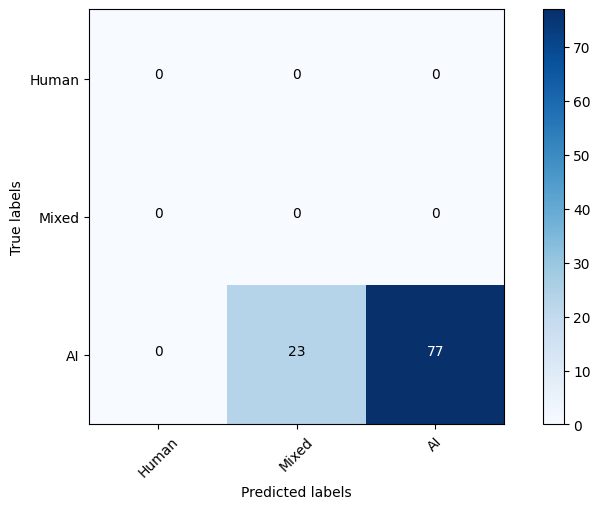

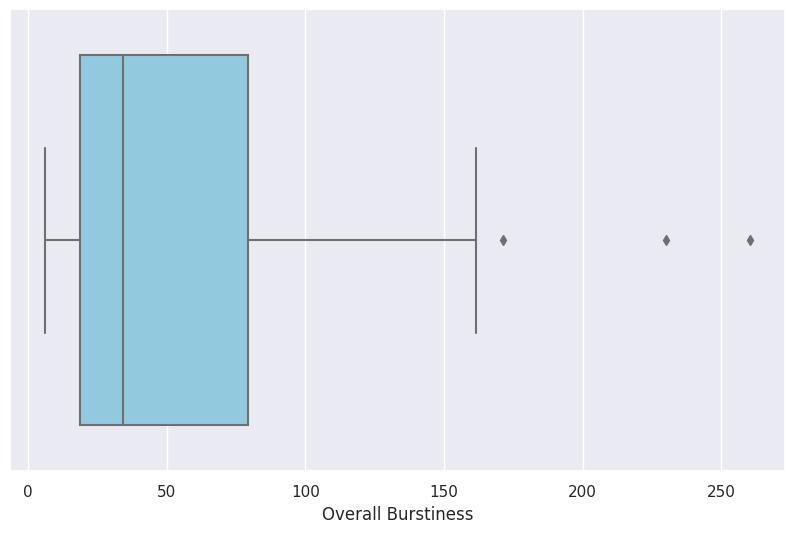

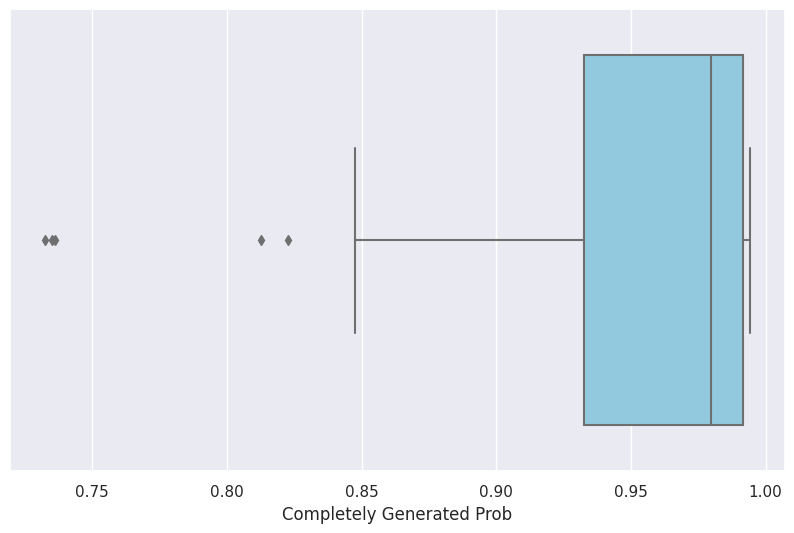

In [ ]:
if dashboard_title == "":
    display_dashboard(input_articles, results)
else:
    display_dashboard(input_articles, results, dashboard_title)